Reading image:  images/bola_00.bmp
	 Encode I-Frame and store as:  images/seq0_00.jpeg
	 Decode I-Frame:  images/seq0_00.jpeg
	 Encode P-Frame and store as:  images/seq1_00.jpeg
	 Decode P-Frame:  images/seq1_00.jpeg
	 Encode P-Frame with Motion Estimation and store as:  images/seq1_00.jpeg
	 Decode P-Frame with Motion Compensation:  images/seq1_00.jpeg
Reading image:  images/bola_01.bmp
	 Encode I-Frame and store as:  images/seq0_01.jpeg
	 Decode I-Frame:  images/seq0_01.jpeg
	 Encode P-Frame and store as:  images/seq1_01.jpeg
	 Decode P-Frame:  images/seq1_01.jpeg
	 Encode P-Frame with Motion Estimation and store as:  images/seq1_01.jpeg
	 Decode P-Frame with Motion Compensation:  images/seq1_01.jpeg
Reading image:  images/bola_02.bmp
	 Encode I-Frame and store as:  images/seq0_02.jpeg
	 Decode I-Frame:  images/seq0_02.jpeg
	 Encode P-Frame and store as:  images/seq1_02.jpeg
	 Decode P-Frame:  images/seq1_02.jpeg
	 Encode P-Frame with Motion Estimation and store as:  images/seq1_02.j

(<matplotlib.axes._subplots.AxesSubplot at 0x29efc0ec6a0>,
 [0, 10, 0, 0.1])

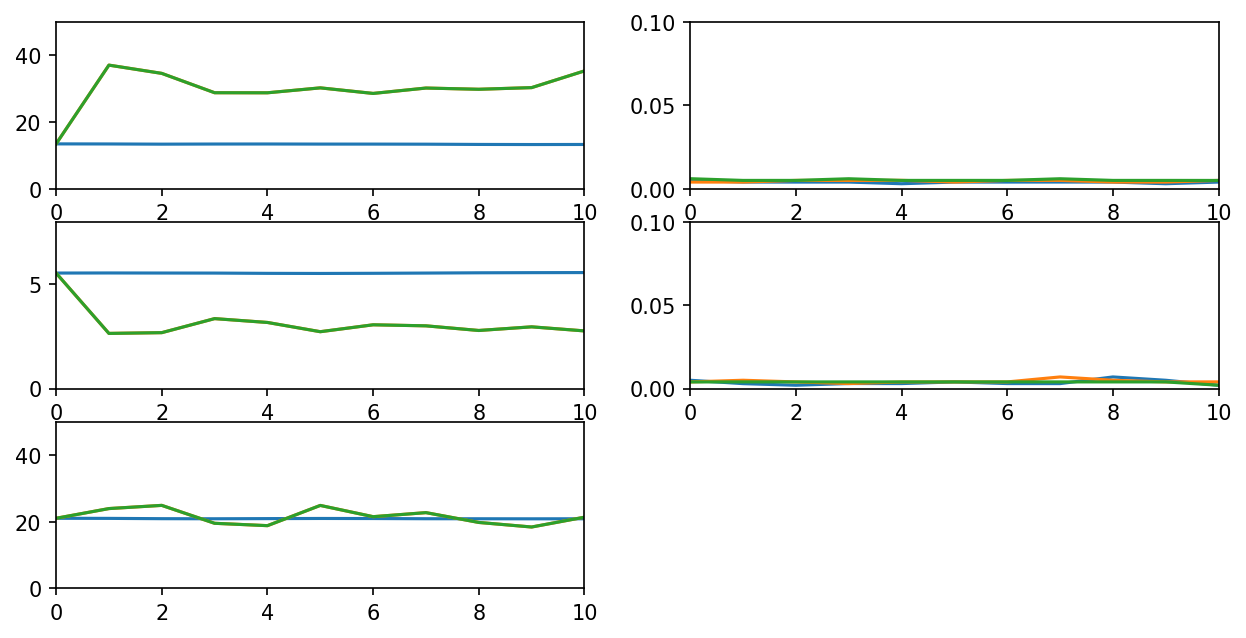

In [131]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import os
import sys
import time
import cv2

##########################################################################
#
#   function to measure the SNR and PSNR
#
##########################################################################

def measure_PSNR_SNR(img_orig, img_final):
    Max = 255 # for the uint8 datatype
    Dim = np.prod(img_orig.shape)
    img_b = img_orig.astype(np.float64)
    img_e = img_final.astype(np.float64)
    pot_img = np.sum( img_b ** 2 )/Dim
    pot_err = np.sum((img_b - img_e)**2)/Dim 
    SNR = 10 * np.log10( pot_img / pot_err )
    PSNR = 10 * np.log10( Max**2 / pot_err ) # for the uint8 datatype
    return PSNR, SNR

##########################################################################
#
#   function to measure entropy
#
##########################################################################

def measure_Entropy(x):
    Max= 255 # for the uint8 datatype
    prob, dummy = np.histogram(x.ravel(),np.arange(0,Max),density=True)
    return -sum(prob*np.log2(prob+sys.float_info.min))

##########################################################################
#
#   function to measure the compression
#
##########################################################################


def measure_CompressionRatio(img_orig, img_comp):
    size_ImgOrig = os.path.getsize(img_orig)
    size_ImgComp = os.path.getsize(img_comp) 
    return size_ImgOrig / size_ImgComp 


def dither(x):
    x = x / 256.0
    c = len(x[1,:]) 
    l = len(x[:,1])
    for kl in range(l):
        for kc in range(c):
            oldpixel = x[kl,kc]             
            newpixel = oldpixel > 0.5 
            x[kl,kc] = newpixel
            quant_error = oldpixel - newpixel
            if kc != c-1:
                x[kl,kc+1] = x[kl,kc+1] + 7./16 * quant_error
            if kl != l-1:
                if kc!=0:
                    x[kl+1,kc-1] = x[kl+1,kc-1] + 3./16 * quant_error
                x[kl+1,kc] = x[kl+1,kc] + 5./16 * quant_error
                if kc != c-1:
                    x[kl+1,kc+1] = x[kl+1,kc+1] + 1./16 * quant_error
    x = x * 255;                
    return x

def get_MotionVector(block,window):
    vect = 0
    best_block = np.zeros( Dim_block,Dim_block )
    return best_block, vect

def motion_estimation(fr_actual, fr_ref):
    Dim_block = 8  # it means 8x8
    Dim_window = 7 # for left right up and down
    NL = 0 
    NC = 0 
    pos_mov_x = 0
    pos_mov_y = 0
    vect_mov_x = np.zeros( (NL/Dim_block,NC/Dim_block) )
    vect_mov_y = np.zeros( (NL/Dim_block,NC/Dim_block) )
    fr_estimate = 0
         
    return fr_estimate, vect_mov_x, vect_mov_y, pos_mov_x, pos_mov_y

def motion_compensation(fr_ref, vect_mov_x, vect_mov_y):
    Dim_block = 8  
    NL = len(fr_ref[:,1])
    NC = len(fr_ref[1,:])
    fr_est = np.zeros( (NL,NC) )
    return fr_est

    
##########################################################################
#
#   Main script
#
##########################################################################

# number of frames
N = 11 
n = range(N)
seq_snr = np.zeros((N,3))
seq_time_enc = np.zeros((N,3))
seq_time_dec = np.zeros((N,3))
seq_entropy = np.zeros((N,3))
seq_tx_comp = np.zeros((N,3))
quality = 50

# Read all tiff images
# write as jpeg, measure SNR and compression
for k in n:
    image_in = "images/bola_%02d.bmp" % k
    # read image in gray scale
 
    x = cv2.imread( image_in, cv2.IMREAD_GRAYSCALE )
    print("Reading image: ", image_in)
    if k==0: # store the reference frame
        fr_ref = np.array(x)
    # store the actual frame
    fr_actual = np.array(x)
    #####################################
    # first method 
    # - Encode I-frame
    #    
    start_time = time.time()
    code_type = 0
    image_c1 = "images/seq%d_%02d.jpeg" % (code_type, k)
    print("\t Encode I-Frame and store as: ", image_c1)
    cv2.imwrite(image_c1, fr_actual, (cv2.IMWRITE_JPEG_QUALITY, quality))
    seq_entropy[k,code_type] = measure_Entropy(fr_actual) 
    seq_time_enc[k,code_type] = time.time() - start_time
    #
    # - Decode (this only for measurement purposes)
    #
    start_time = time.time()    
    print("\t Decode I-Frame: ", image_c1)
    fr_I = np.array( cv2.imread( image_c1, cv2.IMREAD_GRAYSCALE ) )
    psnr, snr = measure_PSNR_SNR(fr_actual,fr_I)
    seq_snr[k,code_type] = snr
    seq_tx_comp[k,code_type] = measure_CompressionRatio(image_in,image_c1)
    seq_time_dec[k,code_type] = time.time() - start_time
    #
    #####################################
        
    #####################################
    # second method 
    #
    # - Encode P-frame 
    #   without motion estimation
    #
    start_time = time.time()
    code_type = 1
    image_c2 = "images/seq%d_%02d.jpeg" % (code_type, k)
    print("\t Encode P-Frame and store as: ", image_c2)
    if k==0: # first is  I-frame
        fr_diff = fr_actual
    else: # all the others are P-frames
        fr_diff = fr_actual - fr_ref + 128.
    cv2.imwrite(image_c2, fr_diff.astype('uint8'), (cv2.IMWRITE_JPEG_QUALITY, quality))
    seq_entropy[k,code_type] = measure_Entropy(fr_diff) 
    seq_time_enc[k,code_type] = time.time() - start_time
    #
    #  - Decode P-frames
    #
    start_time = time.time()
    print("\t Decode P-Frame: ", image_c2)
    fr_P = np.array( cv2.imread( image_c2, cv2.IMREAD_GRAYSCALE ) )
    if k==0:
        fr_act_est = fr_P
    else:
        fr_act_est = fr_P + fr_ref - 128.
        
    psnr, snr = measure_PSNR_SNR(fr_actual,fr_act_est)
    seq_snr[k,code_type] =  snr
    # store final image, no need to compress again
    image_c2r = "images/seq%dr_%02d.bmp" % (code_type, k)
    cv2.imwrite(image_c2r, fr_act_est.astype('uint8'))
    seq_tx_comp[k,code_type] = measure_CompressionRatio(image_in,image_c2)
    seq_time_dec[k,code_type] = time.time() - start_time
    #
    #####################################

    #####################################
    # Third method 
    #
    # - Encode P-frame 
    #   with motion estimation
    #
    start_time = time.time()
    code_type = 2
    image_c3 = "images/seq%d_%02d.jpeg" % (code_type, k)
    image_c3est = "images/seq%dest_%02d.bmp" % (code_type, k)
    print("\t Encode P-Frame with Motion Estimation and store as: ", image_c2)
    if k==0: # first is  I-frame
        fr_est = 0.*fr_actual
        fr_diff = fr_actual
    else: # all the others are P-frames
        fr_est = fr_ref
        #fr_est, vect_mov_x, vect_mov_y, pos_vect_x, pos_vect_y = motion_estimation(fr_actual, fr_ref)
        fr_diff = fr_actual - fr_est + 128.            

    cv2.imwrite(image_c3, fr_diff.astype('uint8'), (cv2.IMWRITE_JPEG_QUALITY, quality))
    cv2.imwrite(image_c3est, fr_est.astype('uint8'))
    seq_entropy[k,code_type] = measure_Entropy(fr_diff) 
    seq_time_enc[k,code_type] = time.time() - start_time
    #
    #  - Decode P-frames with motion compensation
    #
    start_time = time.time()
    print("\t Decode P-Frame with Motion Compensation: ", image_c2)
    fr_P = np.array( cv2.imread( image_c3, cv2.IMREAD_GRAYSCALE ) )
    if k==0:
        fr_act_est = fr_P
    else:
        fr_est = fr_ref
        #fr_est = motion_compensation(fr_ref, vect_mov_x, vect_mov_y)
        fr_act_est = fr_est + fr_P - 128.

    psnr, snr = measure_PSNR_SNR(fr_actual,fr_act_est)
    seq_snr[k,code_type] =  snr
    # store final image, no need to compress again
    image_c3r = "images/seq%dr_%02d.bmp" % (code_type, k)
    cv2.imwrite(image_c3r, fr_act_est.astype('uint8'))
    seq_tx_comp[k,code_type] = measure_CompressionRatio(image_in,image_c3)
    seq_time_dec[k,code_type] = time.time() - start_time
    #
    #####################################

##########################################################################
#
#   Show results
#
##########################################################################

plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(321),plt.plot(n,seq_tx_comp[:,0],n,seq_tx_comp[:,1],n,seq_tx_comp[:,2]),plt.axis([0, N-1, 0, 50])
plt.subplot(323),plt.plot(n,seq_entropy[:,0],n,seq_entropy[:,1],n,seq_entropy[:,2]),plt.axis([0, N-1, 0, 8])
plt.subplot(325),plt.plot(n,seq_snr[:,0],n,seq_snr[:,1],n,seq_snr[:,2]),plt.axis([0, N-1, 0, 50])
plt.subplot(322),plt.plot(n,seq_time_enc[:,0],n,seq_time_enc[:,1],n,seq_time_enc[:,2]),plt.axis([0, N-1, 0, 1e-1])
plt.subplot(324),plt.plot(n,seq_time_dec[:,0],n,seq_time_dec[:,1],n,seq_time_dec[:,2]),plt.axis([0, N-1, 0, 1e-1])
    